# Statistical forecast using ARIMA

This notebook tries to use Auto Regressive Integrated Moving Average (ARIMA) to forecast the bitcoin. The error is calculated using root mean squared error.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

from sklearn.metrics import mean_squared_error
import math

# turn off warnings
import warnings
warnings.simplefilter("ignore")

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

## Import code from *data preprocessing* notebook

In [2]:
import ipynb.fs  # Boilerplate required
# only import definitions
from .defs.data_preprocessing import loadCoinMarketCap

In [3]:
matplotlib.rcParams['figure.figsize'] = 15,6

## Load historical data into a dataframe

In [4]:
df = loadCoinMarketCap(
    # only consider coins having at least half a year of samples
    minSamples   = 180,
    minMarketCap = 1*1000*1000*1000, # 1 billion
    minVolume    = 1*1000*1000*1000, # 1 billion
)
# some constants
COL_VOLUME = "volume"
COL_MARKET = "marketcap"
COL_NAME   = "name"
COL_OPEN   = "open"
COL_CLOSE  = "close"
COL_HIGH   = "high"
COL_LOW    = "low"
print(df.head())
print("Currencies: {}".format(", ".join(df[COL_NAME].unique())))

Samples filled: 5
Loaded 14 currencies, 11469 samples.
               slug name    open    high     low   close  volume     marketcap
date                                                                          
2013-04-28  bitcoin  BTC  135.30  135.98  132.10  134.21     0.0  1.500520e+09
2013-04-29  bitcoin  BTC  134.44  147.49  134.00  144.54     0.0  1.491160e+09
2013-04-30  bitcoin  BTC  144.00  146.93  134.05  139.00     0.0  1.597780e+09
2013-05-01  bitcoin  BTC  139.00  139.89  107.72  116.99     0.0  1.542820e+09
2013-05-02  bitcoin  BTC  116.38  125.60   92.28  105.21     0.0  1.292190e+09
Currencies: BTC, ETH, XRP, BCH, LTC, XLM, NEO, MIOTA, ETC, QTUM, EOS, TRX, USDT, SNT


## Select a currency to work on

In [5]:
currency = "BTC"

Scale functions

count     1796.000000
mean      1645.939165
std       3140.309323
min         68.430000
25%        278.457500
50%        501.010000
75%        921.155000
max      19497.400000
Name: BTC, dtype: float64


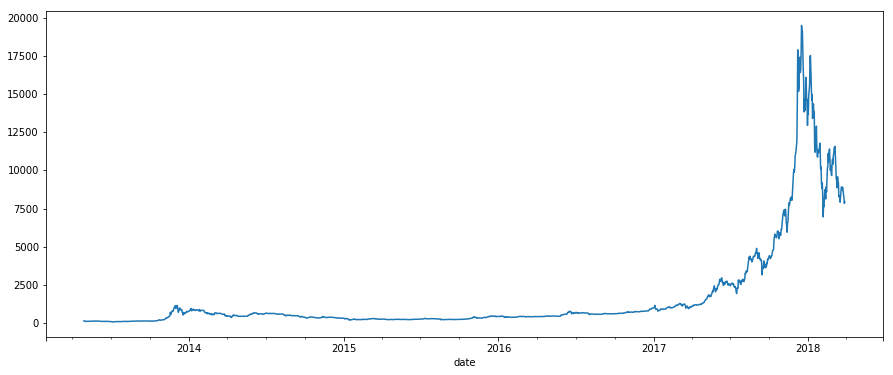

In [6]:
dfCoin = df.loc[df[COL_NAME] == currency]
# only keep close column
sCoin = dfCoin[COL_CLOSE]
sCoin.name = currency
sCoin.plot()
print(sCoin.describe())
pass

## Set parameters, split dataset into train/test

* **n_test**: number of test samples at the end of the series, used to evaluate the forecast.
* **window**: window size used for moving average

In [7]:
n_test = 30
# split into train and test data set
trainTs = sCoin[:-n_test]
testTs = sCoin[-n_test:]

# we will evaluate the model using testTs
window = 7

Scale train time series using log function.

In [8]:
trainTsLog = np.log(trainTs)

## Stationary

The [ADFuller Test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) is used to determine if a time series is stationary.

First some function is provided to plot the moving average and standard deviation of the time series. Another function is provide to run the **adfulller** test.

**ADFulller Test**

Assume null-hypthesis H0, the time series has a unit-root, therefore it is not stationarys. If H0 is rejected, the time series is stationary.

The **p-value** of this test decideds if H0 is rejected or not:
* p > 0.05: accept H0 --> series is **not** stationary
* p <= 0.05: reject H0 --> series is stationary

In [9]:
def plotStats(ts, window=window):
    tsMean = ts.rolling(window=window, center=False).mean()
    tsStd = ts.rolling(window=window, center=False).std()

    plt.plot(ts, color="blue", label="Series")
    plt.plot(tsMean, color="red", label="Moving Average")
    plt.plot(tsStd, color="yellow", label="Moving Std. Deviation")
    plt.legend(loc="best")
    plt.title("Moving Average and Moving Std. Deviation")
    plt.show()

def runAdfullerTest(ts, label):
    print("Adfuller results for: {}".format(label))
    dftest = adfuller(ts)
    print("{:20s}: {:}".format("Test Statistic", dftest[0]))
    print("{:20s}: {:}".format("p-value", dftest[1]))    
    print("{:20s}: {:}".format("#Lags used", dftest[2]))
    print("{:20s}: {:}".format("#Samples", dftest[3]))
    for k, v in dftest[4].items():
        print("{:20s}: {:}".format("Critical Value {}".format(k), v))

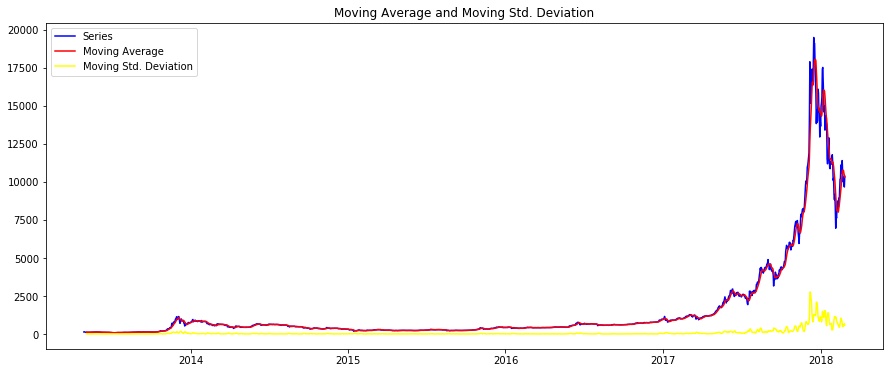

Adfuller results for: Bitcoin
Test Statistic      : -1.3732929455495133
p-value             : 0.5950107516903455
#Lags used          : 22
#Samples            : 1743
Critical Value 1%   : -3.4341072901136798
Critical Value 5%   : -2.8631996341506962
Critical Value 10%  : -2.56765354078555


In [10]:
plotStats(trainTs)
runAdfullerTest(trainTs, "Bitcoin")

The **p-value** is close to one, so this time series is not stationary.

To remove the trend in the time series, the log transformation of the time series is used.

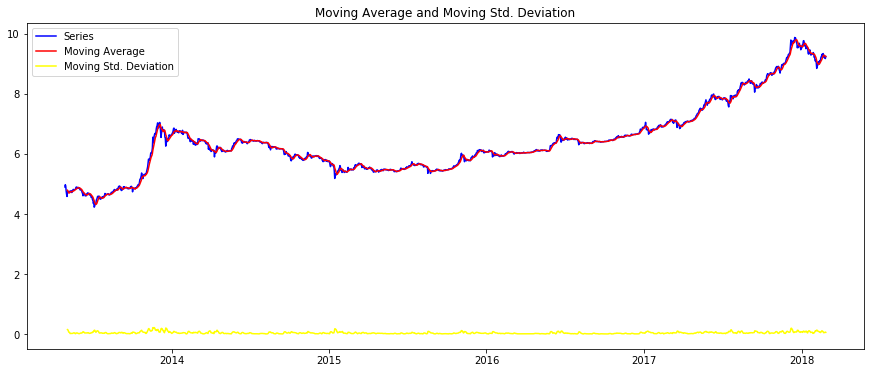

Adfuller results for: log(Bitcoin)
Test Statistic      : -0.13020635442333744
p-value             : 0.9463455064460641
#Lags used          : 23
#Samples            : 1742
Critical Value 1%   : -3.4341094501874854
Critical Value 5%   : -2.8632005876775297
Critical Value 10%  : -2.567654048515701


In [11]:
plotStats(trainTsLog)
runAdfullerTest(trainTsLog, "log(Bitcoin)")

This time series is as well not stationary.

## Make the time series stationary

There are serveral methods to try to make a time series stationary. Here some are tried out.

### Remove moving average from time series

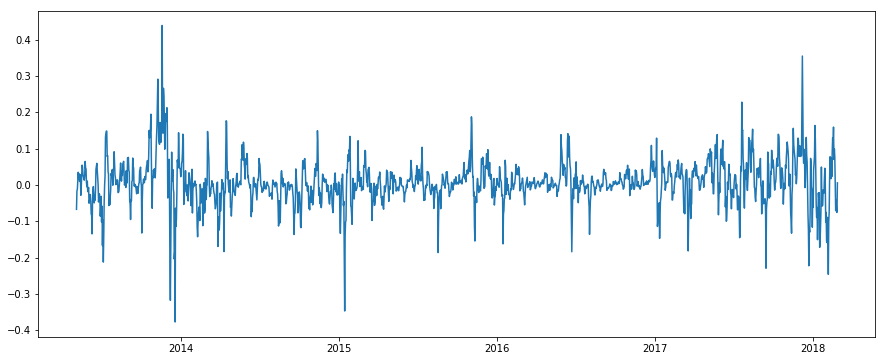

In [12]:
# remove moving average from series
movingAvg = trainTsLog.rolling(window=window, center=False).mean()
trainTsLogAvgDiff = trainTsLog - movingAvg

# drop na at beginning of sequence
trainTsLogAvgDiff.dropna(inplace=True)

plt.plot(trainTsLogAvgDiff, label="Train Log Avg. Diff.")
plt.show()

Let's see if the time series is stationary.

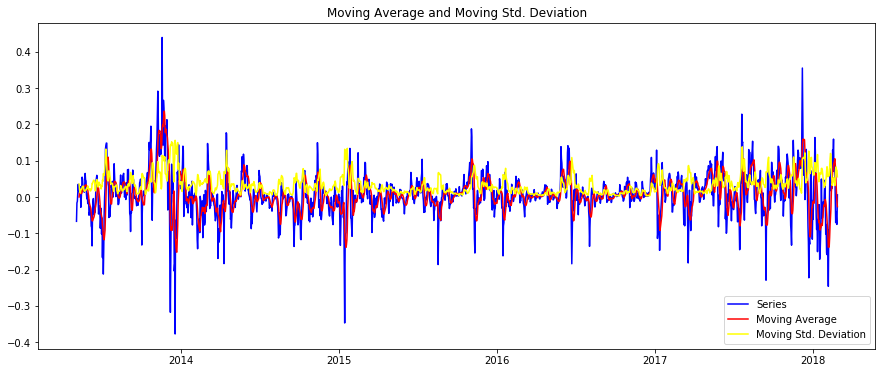

Adfuller results for: Train Log Avg. Diff.
Test Statistic      : -7.445594359536145
p-value             : 5.849913060937777e-11
#Lags used          : 22
#Samples            : 1737
Critical Value 1%   : -3.434120287918905
Critical Value 5%   : -2.8632053717943005
Critical Value 10%  : -2.5676565959447415


In [13]:
# check for stationary
plotStats(trainTsLogAvgDiff)
runAdfullerTest(trainTsLogAvgDiff, "Train Log Avg. Diff.")

This time series is stationary. The **p-value** is << 0.05. **Test Statistic** is less than **Critical Value 1%**.

### Seasonality Adjustment by Differencing

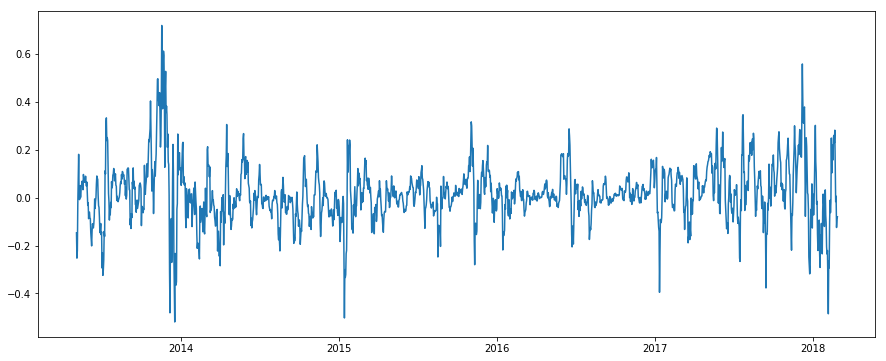

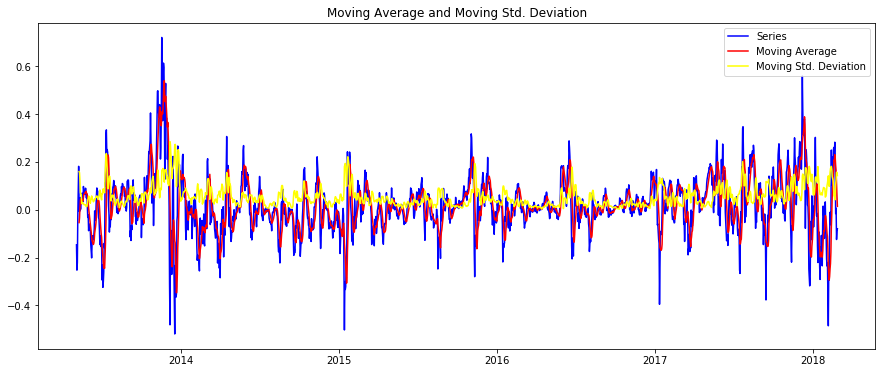

Adfuller results for: Train Log Shift Diff.
Test Statistic      : -6.693148643295242
p-value             : 4.061593509815423e-09
#Lags used          : 22
#Samples            : 1736
Critical Value 1%   : -3.4341224629678426
Critical Value 5%   : -2.863206331927479
Critical Value 10%  : -2.5676571071932934


In [14]:
trainTsLogShiftDiff = trainTsLog - trainTsLog.shift(window)
plt.plot(trainTsLogShiftDiff, label="Train Log Shift Diff.")
plt.show()

# get rid of na
trainTsLogShiftDiff.dropna(inplace=True)

# again, test for stationary
plotStats(trainTsLogShiftDiff)
runAdfullerTest(trainTsLogShiftDiff, "Train Log Shift Diff.")

### Take the best stationarized series

The **moving avg.** stationarized series is better than the **shifted** version. The **p-value** is smaller and the **Test Statistic** value is smaller.

In [15]:
trainTsLogDiff = trainTsLogAvgDiff

## Determine the parameters for the ARIMA model

The ARIMA model needs three parameters:
* p: the lag order, this parameter is for AR.
* d: the differencing, this parameter is used for I, we assume 1.
* q: the size of the moving average window, this parameter is for MA.

To determine **p** and **q**, the Partial Autocorrelation Function (PACF) and the Autocorrelation function (ACF) plots can be used.

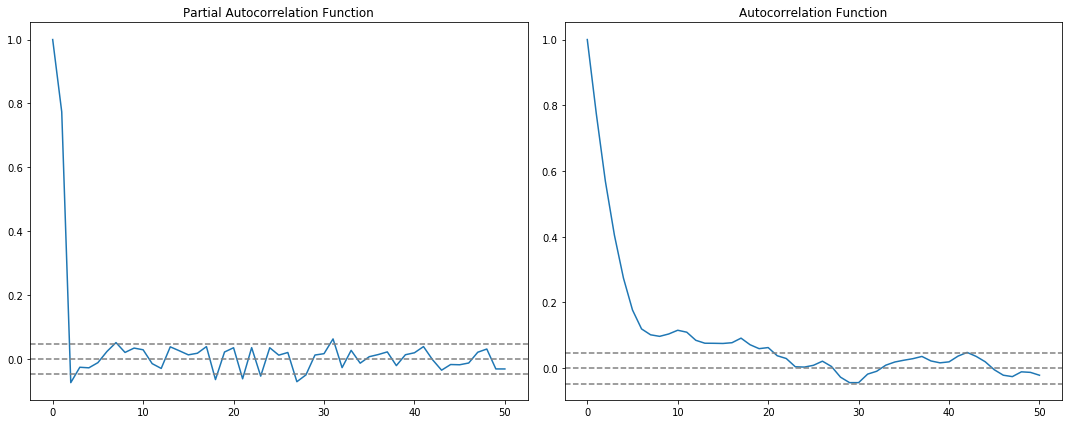

In [16]:
# calculate PACF / ACF
nlagsPacf = 50
nlagsAcf = 50
lagPacf = pacf(trainTsLogDiff, nlags=nlagsPacf, method="ols")
lagAcf = acf(trainTsLogDiff, nlags=nlagsAcf)

# plot pacf/aacf
plt.subplot(121)
plt.plot(lagPacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(trainTsLogDiff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(trainTsLogDiff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')

plt.subplot(122) 
plt.plot(lagAcf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(trainTsLogDiff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(trainTsLogDiff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

plt.tight_layout()

The dotted lines in the plot above mark the confidence interval.

* PACF enters the confidence interval at around 2, so **p=2**.
* ACF enters the confidence interval at around 21, so **q=21**.

Below is yet another view.

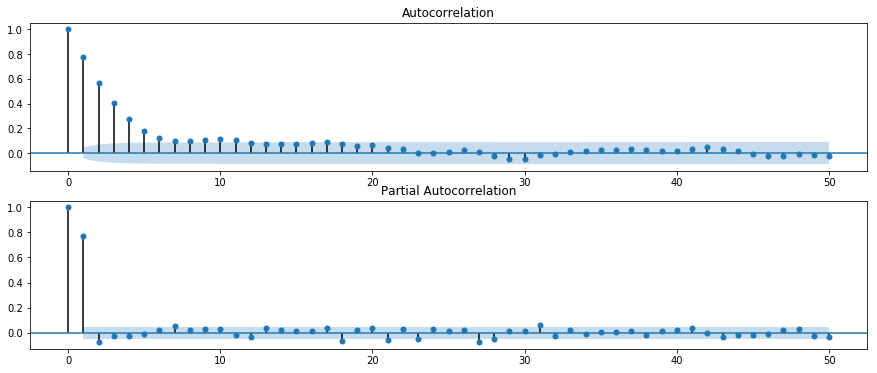

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure()
plt.subplot(211)
plot_acf(trainTsLogDiff, ax=plt.gca(),lags=nlagsAcf)
plt.subplot(212)
plot_pacf(trainTsLogDiff, ax=plt.gca(), lags=nlagsPacf)
plt.show()

The analyse of the charts gives the parameters for ARIMA:
* p=2
* q=21

We assume d=1.

## Build the **best** ARIMA model

p and q are taken from above. For differencing, we apply 1.

In [18]:
p = 2
q = 21
model = ARIMA(trainTsLog, order=(p, 1, q))
res = model.fit(disp=-1)

/home/dahuebi/PML/cas-pml-prj/venv/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Print the resulting model.

In [19]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.BTC   No. Observations:                 1765
Model:                ARIMA(2, 1, 21)   Log Likelihood                2998.126
Method:                       css-mle   S.D. of innovations              0.044
Date:                Sun, 01 Apr 2018   AIC                          -5946.252
Time:                        23:57:55   BIC                          -5809.354
Sample:                    04-29-2013   HQIC                         -5895.668
                         - 02-26-2018                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0024      0.001      1.764      0.078      -0.000       0.005
ar.L1.D.BTC      0.7474      0.025     30.126      0.000       0.699       0.796
ar.L2.D.BTC     -0.9534      0.029    -32.925      0.000      -1.010      -0.897
ma.L1.D.BTC     -0.7489      0.034    -22.097      0.000      -0.815      -0.682
ma.L2.D.BTC      0.9270      0.043     21.804      0.000       0.844       1.010
ma.L3.D.BTC      0.0155      0.038      0.404      0.686      -0.060       0.091
ma.L4.D.BTC      0.0161      0.038      0.420      0.674      -0.059       0.091
ma.L5.D.BTC     -0.0048      0.038     -0.125      0.900      -0.079       0.070
ma.L6.D.BTC      0.0809      0.038      2.117      0.034       0.006       0.156
ma.L7.D.BTC     -0.0487      0.038     -1.264      0.206      -0.124       0.027
ma.L8.D.BTC      0.0858      0.039      2.221      0.026       0.010       0.161
ma.L9.D.BTC     -0.0283      0.038     -0.738      0.460      -0.103       0.047
ma.L10.D.BTC     0.0576      0.038      1.534      0.125      -0.016       0.131
ma.L11.D.BTC     0.0242      0.035      0.693      0.488      -0.044       0.093
ma.L12.D.BTC    -0.0090      0.035     -0.258      0.796      -0.077       0.059
ma.L13.D.BTC     0.0800      0.036      2.197      0.028       0.009       0.151
ma.L14.D.BTC    -0.0030      0.037     -0.082      0.935      -0.076       0.069
ma.L15.D.BTC     0.0156      0.039      0.397      0.691      -0.061       0.093
ma.L16.D.BTC    -0.0294      0.041     -0.723      0.470      -0.109       0.050
ma.L17.D.BTC     0.1295      0.041      3.152      0.002       0.049       0.210
ma.L18.D.BTC    -0.1021      0.041     -2.521      0.012      -0.182      -0.023
ma.L19.D.BTC     0.0824      0.043      1.936      0.053      -0.001       0.166
ma.L20.D.BTC     0.0180      0.035      0.509      0.611      -0.051       0.088
ma.L21.D.BTC     0.0128      0.027      0.477      0.634      -0.040       0.066
                                    Roots                                     
==============================================================================
                  Real           Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             0.3920           -0.9462j            1.0242           -0.1875
AR.2             0.3920           +0.9462j            1.0242            0.1875
MA.1             1.1090           -0.2391j            1.1345           -0.0338
MA.2             1.1090           +0.2391j            1.1345            0.0338
MA.3             1.0137           -0.5782j            1.1670           -0.0825
MA.4             1.0137           +0.5782j            1.1670            0.0825
MA.5             0.7464           -0.8522j            1.1329           -0.1355
MA.6             0.7464           +0.8522j            1.1329            0.1355
MA.7             0.4227           -0.9507j            1.0404           -0.1834
MA.8             0.4227    

Print the trainings data and the ARIMA time series.

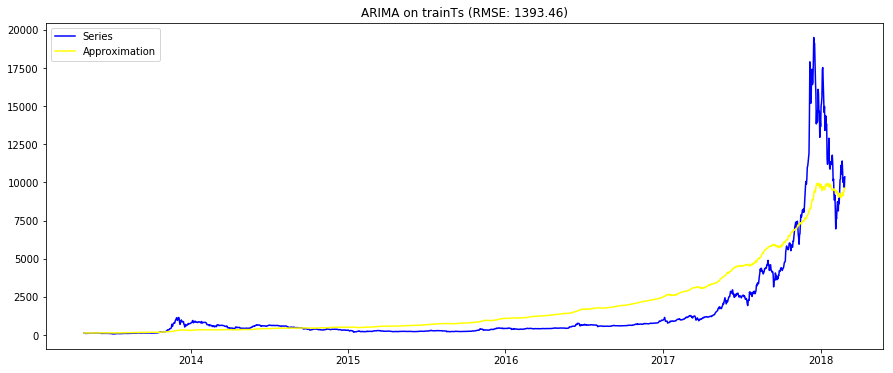

In [20]:
# plot whole time series
plt.plot(trainTs, color="blue", label="Series")

# plot aproximation
predTrainDiff = pd.Series(res.fittedvalues, copy=True)
# calculaive cumulative differences
predTrainDiffCumSum = predTrainDiff.cumsum()
# add cumulative differences to origin time series
predTrainLog = pd.Series(trainTsLog.iloc[0], index=trainTsLog.index)
predTrainLog = predTrainLog.add(predTrainDiffCumSum, fill_value=0)
# transform to original scale
predTrain = np.exp(predTrainLog)

plt.plot(predTrain, color="yellow", label="Approximation")
plt.legend(loc="best")
rmse = math.sqrt(mean_squared_error(predTrain, trainTs))
plt.title("ARIMA on trainTs (RMSE: {:3.2f})".format(rmse))
plt.show()

## Forecast time serie using ARIMA

Forcast **n_test** data points, compare with **testTs**.

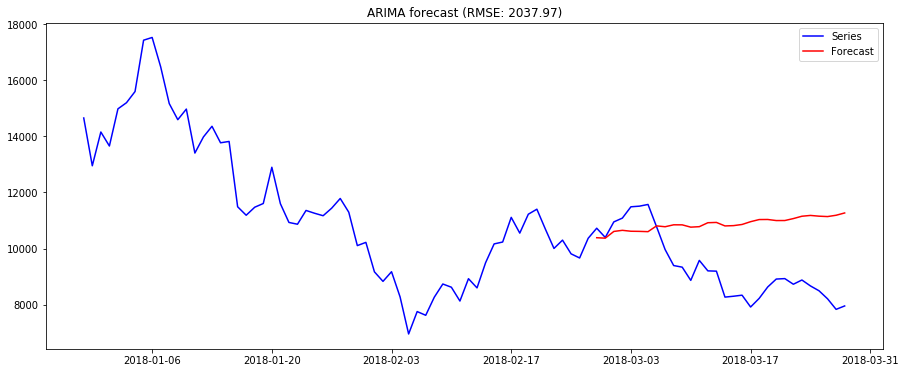

In [21]:
# plot original time series
plt.plot(sCoin[-3*n_test:], label="Series", color="blue")
predLog = res.forecast(steps=n_test)
predLog = predLog[0] # ignore stderr, conf_int
pred = np.exp(predLog)
rmse = math.sqrt(mean_squared_error(pred, testTs))
plt.plot(pd.Series(pred, index=testTs.index), label="Forecast", color="red")
plt.legend(loc="best")
plt.title("ARIMA forecast (RMSE: {:0.2f})".format(rmse))
plt.show()